The Rubber Band Analogy

Let’s magine a moving average as a rubber band stretched across a chart. The stock price, represented by the current market price, moves above and below this band as in the above chart. Like a rubber band tends to snap back to its resting position when stretched, stock prices often exhibit a tendency to revert to their moving averages over time.

Key Components:

Moving Average: Acts as the central point or “resting position” of the rubber band.

Stock Price: Moves dynamically, stretching above or below the moving average.

Elasticity: Varies between different stocks, influencing how far and how quickly prices deviate from and return to the moving average.

In [19]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
import sys
from datetime import datetime, date

today = str(date.today())

# Define the stock ticker and the moving average period
ticker = '^nsei'
ma_period = 200

# Fetch historical data for the last 2 years
stock_data = yf.download(ticker, period="10y")


[*********************100%%**********************]  1 of 1 completed


Elasticity of Stock

To study the entry and exit of using this rubber band effect, we need to identfiy the pattern when the peak and trough happens — when the price will likely to be snapped back to the moving average from above or below the moving average, as each stock has different ‘elasticity’.

Let’s take a look at a few example of stock of different segments. I further add a subplot to indicate the return of using this strategy … If an investor can “accurately time” the market by buying at troughs (green dots) when the stock rebounds and selling and wait when it peaks (red dots) using this indicator, the potential returns could significantly outperform a traditional buy-and-hold strategy, potentially multiplying the initial investment several times over!!

We cannot simply apply a +10% / -10% or any percentage universally as each stock has different elasticity. We can’t simply define the over sold and over bought level like RSI’s 30/70 rules. We must try to identify the stock’s peak and trough from it’s historical behavior around the moving average.

In [20]:
if len(stock_data) < ma_period:
    sys.exit(f'Data size too small for {ticker}, program aborted.')

# Calculate the xx-day Moving Average (x_day_MA)
stock_data['x_day_MA'] = stock_data['Close'].rolling(window=ma_period).mean()

# Adjust the percentage over/under x-MA calculation
stock_data['Pct_Over_MA'] = (stock_data['Close'] - stock_data['x_day_MA']) / stock_data['x_day_MA'] * 100

# Handle NaN values
stock_data['Pct_Over_MA'].fillna(0, inplace=True)

# Prepare data for neural network
def prepare_data(stock_data, ma_period):
    X = []
    for i in range(ma_period, len(stock_data)):
        X.append(stock_data['Pct_Over_MA'].iloc[i-ma_period:i].values)
    X = np.array(X)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    
    return X

# Create the neural network model
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(200, input_dim=input_dim, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='linear'))  # Two outputs: window_peak and window_trough
    model.compile(optimizer='adam', loss='mse')
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model


Stock prices are influenced by numerous factors, making their movements highly non-linear and complex. Neural networks are well-suited to capture these non-linear relationships, making them ideal for predicting price movements that oscillate around moving averages. By training on historical data, the model learns patterns that may indicate the likelihood of price reversion or continuation.

The input to the neural network is not the stock price, but the % of the price above or below the 200 Moving Average. You can test the code by using shorter or longer moving average over a shorter or longer period of course.

Neural Network Architecture:

The model is a simple feedforward neural network with three layers:

Input Layer: Takes the last 200 days of deviation data as input.

Hidden Layers: Two dense layers with ReLU activation and dropout for regularization. The layers will try to capture complex relationships in the data.

Output Layer: Predicts two key values — window_peak and window_trough, which represent the optimal lookback periods to identify local maxima (peaks) and minima (troughs) in the price data.

Here is the visual representation of the network, I used plot_model to obtain such image:

In [21]:
# Prepare the data
X = prepare_data(stock_data, ma_period)

# Split the data into training and testing sets
split_index = int(0.5 * len(X))  # 50/50 training vs testing data
X_train, X_test = X[:split_index], X[split_index:]

# Target values (y) are not predefined; the model will attempt to learn the best window_peak and window_trough
y_train = np.random.rand(len(X_train), 2) * 30  # Random values between 0 and 30
y_test = np.random.rand(len(X_test), 2) * 30

# Build and train the model
model = build_model(X_train.shape[1])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Make predictions
predictions = model.predict(X_test)

# Safeguard against NaNs in predictions
def safe_convert_to_int(value):
    if np.isnan(value) or value <= 0:
        return 1  # Default to a safe value
    else:
        return int(value)

best_window_peak = safe_convert_to_int(predictions[-1][0])
best_window_trough = safe_convert_to_int(predictions[-1][1])

You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/50


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 214.1117 - val_loss: 72.7806
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 120.2078 - val_loss: 80.1819
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 120.7364 - val_loss: 80.3559
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 116.5029 - val_loss: 86.2477
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 115.5846 - val_loss: 80.1298
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 100.7385 - val_loss: 73.6061
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111.4123 - val_loss: 80.3260
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110.4550 - val_loss: 75.9037
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 116.5978 - val_loss: 74.5791
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 106.8459 - val_loss: 74.4401
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107.6317 - val_loss: 75.6221
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

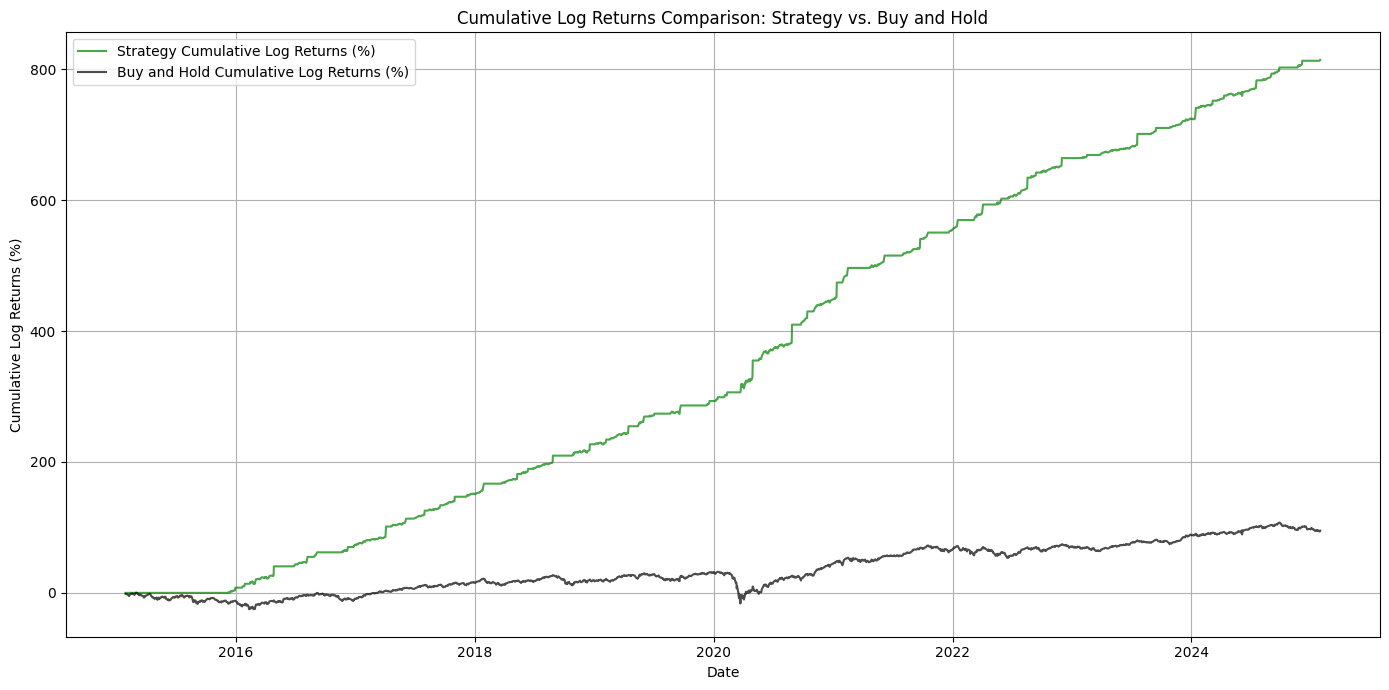

In [22]:
# Find local maxima and minima using the predicted optimal windows
local_maxima = argrelextrema(stock_data['Pct_Over_MA'].values, comparator=np.greater, order=best_window_peak)[0]
local_minima = argrelextrema(stock_data['Pct_Over_MA'].values, comparator=np.less, order=best_window_trough)[0]

# Extract peak and trough values
peak_values = stock_data['Pct_Over_MA'].iloc[local_maxima]
trough_values = stock_data['Pct_Over_MA'].iloc[local_minima]

# Initialize positions array
positions = np.zeros(len(stock_data))

# Define buy and sell signals based on local minima and maxima
for i in range(1, len(stock_data)):
    if i in local_minima:
        positions[i] = 1  # Buy
    elif i in local_maxima:
        positions[i] = -1  # Sell

# Calculate log returns for buy and hold
stock_data['Log_Return_BnH'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

# Initialize strategy returns with zeros (log returns start at 0)
strategy_log_returns = np.zeros_like(stock_data['Close'].values)

in_position = False
buy_price = 0

for i in range(1, len(stock_data)):
    if positions[i] == 1 and not in_position:
        # Buy at the closing price
        buy_price = stock_data['Close'].iloc[i]
        in_position = True
        strategy_log_returns[i] = strategy_log_returns[i-1]  # Carry forward previous return
    elif positions[i] == -1 and in_position:
        # Sell at the closing price
        sell_price = stock_data['Close'].iloc[i]
        # Calculate the log return for the sell action
        strategy_log_returns[i] = strategy_log_returns[i-1] + np.log(sell_price / buy_price)
        in_position = False
    elif in_position:
        # Update log returns while holding the position
        current_price = stock_data['Close'].iloc[i]
        daily_log_return = np.log(current_price / stock_data['Close'].iloc[i-1])
        strategy_log_returns[i] = strategy_log_returns[i-1] + daily_log_return
    else:
        # Carry forward the previous return if not in position
        strategy_log_returns[i] = strategy_log_returns[i-1]

# Calculate cumulative log returns for buy and hold strategy
stock_data['Cumulative_Log_Return_BnH'] = stock_data['Log_Return_BnH'].cumsum()

# The log returns for the strategy are already cumulative (as we sum them up)
cumulative_strategy_log_returns = strategy_log_returns

# Plot the results
fig = plt.figure(figsize=(14, 7))

# Plot cumulative log returns
plt.plot(stock_data.index, cumulative_strategy_log_returns * 100, label='Strategy Cumulative Log Returns (%)', color='green', alpha=0.7)
plt.plot(stock_data.index, stock_data['Cumulative_Log_Return_BnH'] * 100, label='Buy and Hold Cumulative Log Returns (%)', color='black', alpha=0.7)

plt.title('Cumulative Log Returns Comparison: Strategy vs. Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Log Returns (%)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

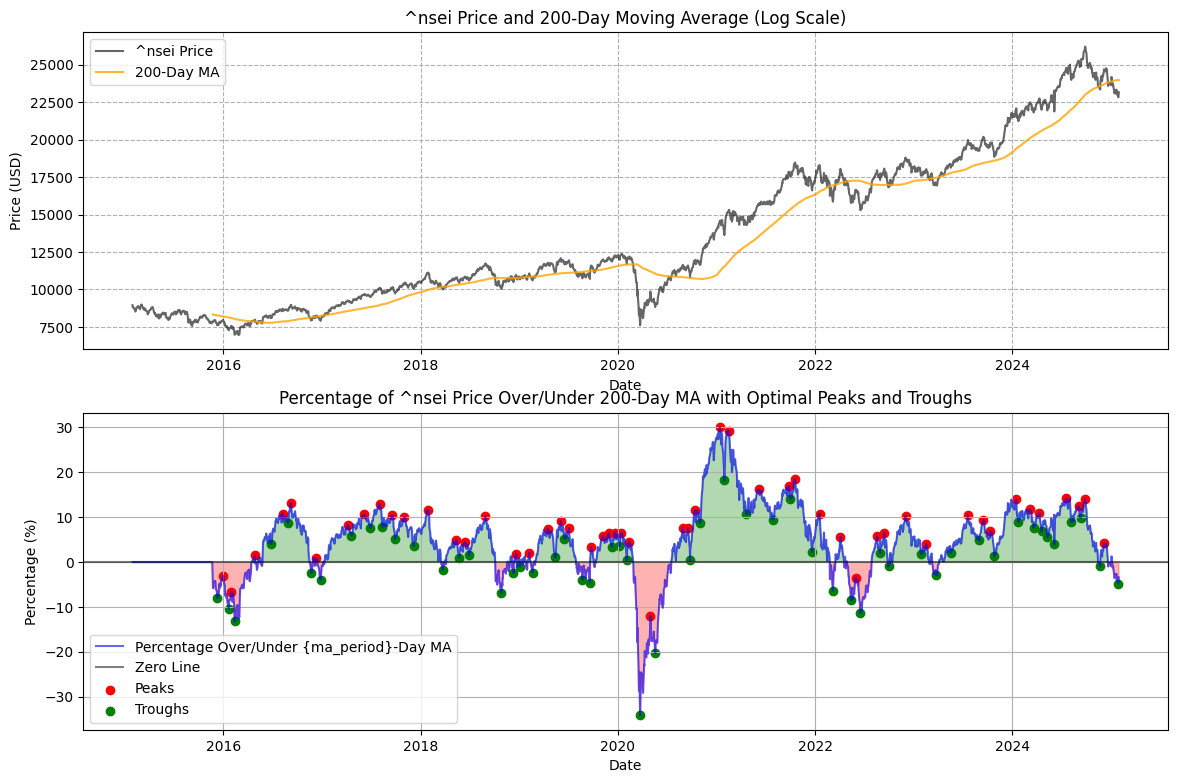

In [23]:
# Plot the results
fig=plt.figure(figsize=(14, 14))

# First subplot: Stock Price and x-Day MA
ax1 = plt.subplot(3, 1, 1)
plt.plot(stock_data.index, stock_data['Close'], label=f'{ticker} Price', color='black',alpha=0.6)
plt.plot(stock_data.index, stock_data['x_day_MA'], label=f'{ma_period}-Day MA', color='orange', alpha=0.8)
plt.title(f'{ticker} Price and {ma_period}-Day Moving Average (Log Scale)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, which="both", ls="--")

# Second subplot: Percentage Over/Under x-Day MA with Peaks and Troughs
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(stock_data.index, stock_data['Pct_Over_MA'], label='Percentage Over/Under {ma_period}-Day MA', color='blue', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, label=f'Zero Line')

# Fill green above 0 and red below 0
plt.fill_between(stock_data.index, stock_data['Pct_Over_MA'], where=(stock_data['Pct_Over_MA'] >= 0), color='green', alpha=0.3)
plt.fill_between(stock_data.index, stock_data['Pct_Over_MA'], where=(stock_data['Pct_Over_MA'] < 0), color='red', alpha=0.3)

plt.scatter(stock_data.index[local_maxima], peak_values, color='red', label='Peaks', marker='o')
plt.scatter(stock_data.index[local_minima], trough_values, color='green', label='Troughs', marker='o')
plt.title(f'Percentage of {ticker} Price Over/Under {ma_period}-Day MA with Optimal Peaks and Troughs')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)


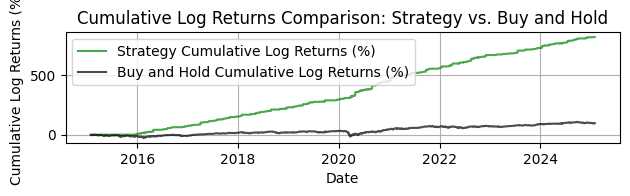

In [24]:
# Plot cumulative log returns
ax3 = plt.subplot(3, 1, 3, sharex=ax1)

plt.plot(stock_data.index, cumulative_strategy_log_returns * 100, label='Strategy Cumulative Log Returns (%)', color='green', alpha=0.7)
plt.plot(stock_data.index, stock_data['Cumulative_Log_Return_BnH'] * 100, label='Buy and Hold Cumulative Log Returns (%)', color='black', alpha=0.7)

plt.title('Cumulative Log Returns Comparison: Strategy vs. Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Log Returns (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()